# [Deep Learning 101] 오토인코더 PyTorch로 구현하기

https://www.youtube.com/watch?v=Yhe7Wm5NbVQ&list=PLfGJDDf2OqlQkHqKB7uonQGeNRfUo_TMe&index=16


In [1]:
# %matplotlib notebook
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 12),
            nn.Tanh(),
            nn.Linear(12, 3)   # Compressed representation
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.Tanh(),
            nn.Linear(12, 64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, 28*28),
            nn.Tanh()       # Output a value between 0 and 1
        )

    def forward(self, x):
        x_encoded = self.encoder(x)
        x = self.decoder(x_encoded)
        return x, x_encoded

In [3]:
# Load and transform the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
# Load the train dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Load the test dataset
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=True)  # Larger batch size for testing

In [4]:
print(train_dataset.data.shape)
print(test_dataset.data.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


In [5]:
# d = next(iter(train_loader))
# print(type(d), len(d))
# x,y = d
# print(x.shape)
# print(y.shape)

In [6]:
# %matplotlib inline

# plt.imshow(x[0].reshape(28,28), cmap="gray")
# print(y[0])

In [7]:
# Initialize the model, loss function, and optimizer
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [13]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.view(img.size(0), -1)  # Flatten the images
        output,_ = model(img)
        loss = criterion(output, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("Training Complete")

Epoch [1/10], Loss: 0.1238
Epoch [2/10], Loss: 0.1354
Epoch [3/10], Loss: 0.1122
Epoch [4/10], Loss: 0.1150
Epoch [5/10], Loss: 0.1252
Epoch [6/10], Loss: 0.1013
Epoch [7/10], Loss: 0.1524
Epoch [8/10], Loss: 0.1184
Epoch [9/10], Loss: 0.1208
Epoch [10/10], Loss: 0.1065
Training Complete


<class 'torch.Tensor'>
torch.Size([1000, 1, 28, 28])


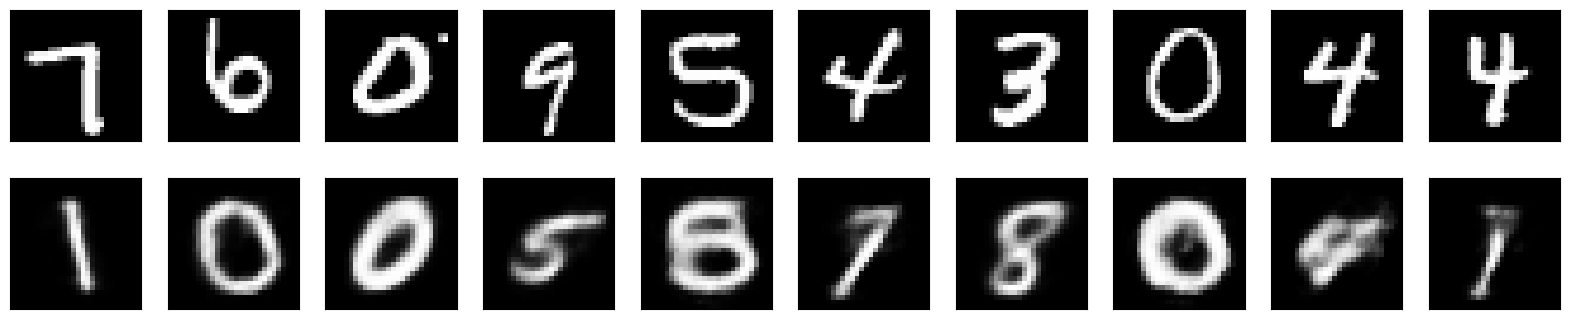

In [14]:
# Testing the model and visualizing some results
# Get a batch of data
dataiter = iter(test_loader)
images, _ = next(dataiter)
images_flattened = images.view(images.size(0), -1)

print(type(images))
print(images.shape)
images.size(0)

# Forward pass the images through the autoencoder
output, _ = model(images_flattened)
output = output.view(output.size(0), 1, 28, 28).detach()

# Visualize the results
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))

# Original images
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.squeeze().numpy(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

plt.show()

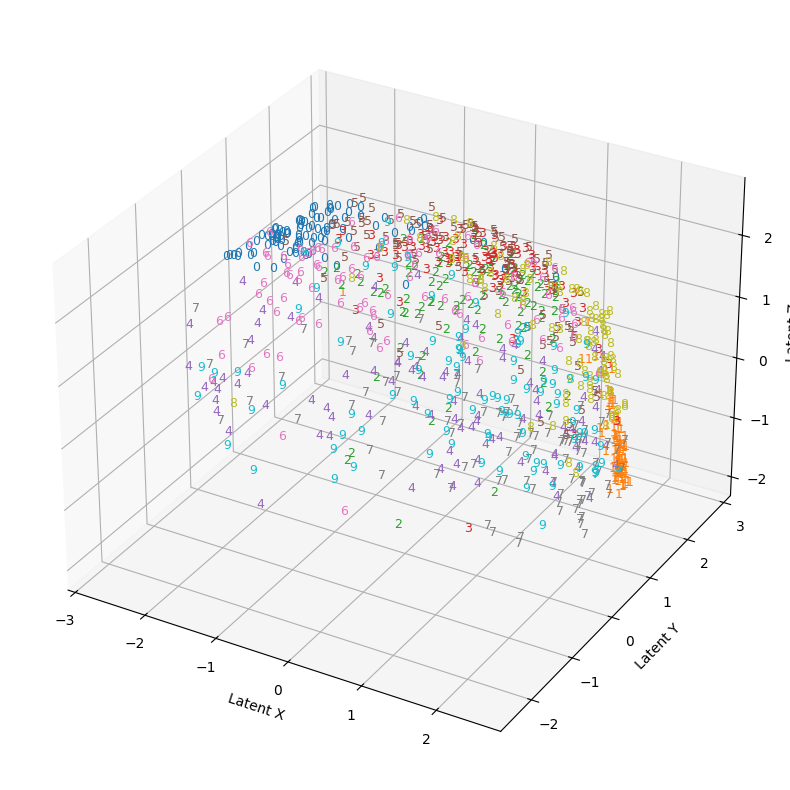

In [16]:
# Testing the model and collecting latent vectors
model.eval()  # Set the model to evaluation mode

latent_vectors = []
labels = []

with torch.no_grad():
    for data in test_loader:
        imgs, lbls = data
        imgs = imgs.view(imgs.size(0), -1)
        _, latents = model(imgs)
        latent_vectors.append(latents)
        labels.append(lbls)

latent_vectors = torch.cat(latent_vectors, dim=0)
labels = torch.cat(labels, dim=0)

# 3D Visualization
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Annotate a subset of points from each label category
for i in range(10):
    indices = np.where(labels == i)[0]
    subset_indices = np.random.choice(indices, size=min(len(indices), 100), replace=False)

    for idx in subset_indices:
        ax.text(latent_vectors[idx, 0].item(), latent_vectors[idx, 1].item(), latent_vectors[idx, 2].item(),
                str(i), color=plt.cm.tab10(i), fontsize=9, ha='center')


# Setting axis limits based on the data range
x_min, x_max = latent_vectors[:, 0].min(), latent_vectors[:, 0].max()
y_min, y_max = latent_vectors[:, 1].min(), latent_vectors[:, 1].max()
z_min, z_max = latent_vectors[:, 2].min(), latent_vectors[:, 2].max()

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_zlim(z_min, z_max)


ax.set_xlabel('Latent X')
ax.set_ylabel('Latent Y')
ax.set_zlabel('Latent Z')

plt.show()